# Variational Inference: Bayesian Neural Networks

(c) 2016-2018 by Thomas Wiecki, updated by Maxim Kochurov

Original blog post: https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
sns.set_context('talk')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = pm.floatX(X)
Y = pm.floatX(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

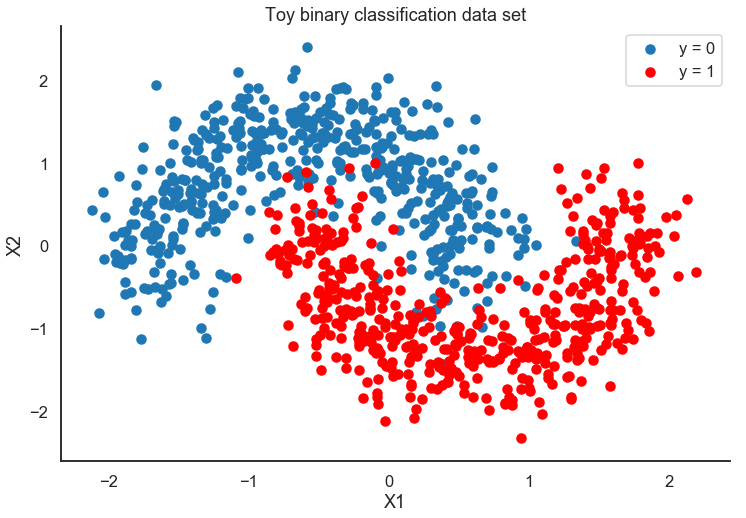

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='y = 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='y = 1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

In [7]:
ann_input = theano.shared(X)
ann_output = theano.shared(Y)

In [8]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [103]:
ann_input = theano.shared(X)
ann_output = theano.shared(Y)

ndim = X.shape[1] # 2

with pm.Model() as logistic_regression_prior:
    weights = pm.Normal('weights', mu=0, sd=.1, shape=ndim) # Define parameter
    linear = pm.math.dot(ann_input, weights)
    class_prob = pm.math.sigmoid(linear)
    
    p = pm.Deterministic('p', pm.math.sigmoid(pm.math.dot(grid_2d, weights)))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('obs', p=class_prob, observed=ann_output)
    
    fit = pm.find_MAP()
    
fit

logp = -431.41, ||grad|| = 0.0016014: 100%|██████████| 25/25 [00:00<00:00, 395.61it/s]  


{'weights': array([ 0.6594888, -1.0508481], dtype=float32),
 'p': array([0.7638813 , 0.75220186, 0.7401412 , ..., 0.2598588 , 0.24779813,
        0.23611864], dtype=float32)}

In [17]:
import pymc3 as pm

with pm.Model() as logistic_regression:
    weights = pm.Flat('weights', shape=2) # Define parameter
    linear = pm.math.dot(X, weights)
    class_prob = pm.math.sigmoid(linear)
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('obs', p=class_prob, observed=Y)
    
    # Find best fitting parameter (maximum a posterior)
    fit = pm.find_MAP()

logp = -285.67, ||grad|| = 0.0055599: 100%|██████████| 26/26 [00:00<00:00, 718.34it/s]  


In [99]:
fit['weights']

array([ 1.1462592, -2.5510144], dtype=float32)

In [100]:
with pm.Model() as logistic_regression_prior:
    weights = pm.Normal('weights', mu=0, sd=.1, 
                        shape=2)
    linear = pm.math.dot(X, weights)
    class_prob = pm.math.sigmoid(linear)
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('obs', p=class_prob, observed=Y)
    
    # Find best fitting parameter (Maximum a Posteiror)
    fit = pm.find_MAP()

logp = -431.41, ||grad|| = 0.0016014: 100%|██████████| 25/25 [00:00<00:00, 1303.45it/s]  


In [101]:
fit['weights']

array([ 0.6594888, -1.0508481], dtype=float32)

In [10]:
ann_input = theano.shared(X)
ann_output = theano.shared(Y)

ndim = X.shape[1] # 2

with pm.Model() as logistic_regression:
    weights = pm.Flat('weights', shape=ndim) # Define parameter
    linear = pm.math.dot(ann_input, weights)
    class_prob = pm.math.sigmoid(linear)
    
    p = pm.Deterministic('p', pm.math.sigmoid(pm.math.dot(grid_2d, weights)))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('obs', p=class_prob, observed=ann_output)
    
    fit = pm.find_MAP()
    
fit

logp = -285.67, ||grad|| = 0.0055599: 100%|██████████| 26/26 [00:00<00:00, 809.84it/s]  


{'weights': array([ 1.1462592, -2.5510144], dtype=float32),
 'p': array([0.9854322 , 0.9830377 , 0.9802577 , ..., 0.0197423 , 0.01696222,
        0.01456781], dtype=float32)}

In [11]:
with logistic_regression:
    ppc = pm.sample_ppc({0: fit}, samples=1)['obs']

100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


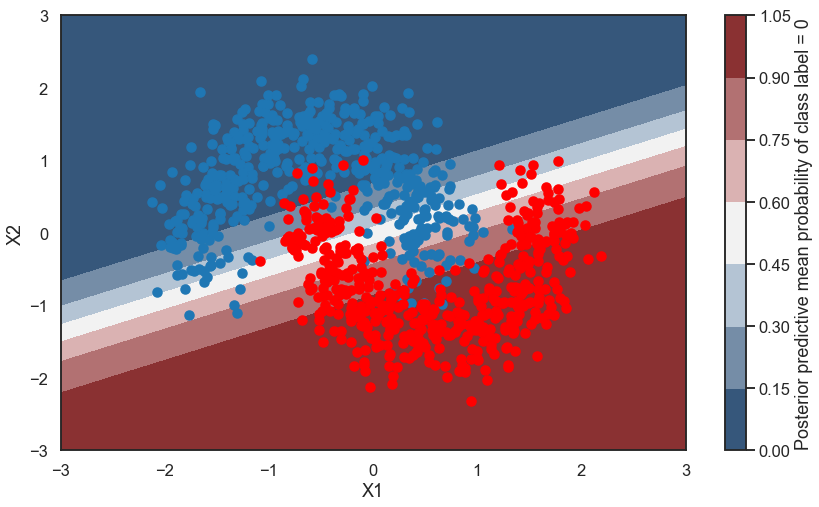

In [14]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], fit['p'].reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

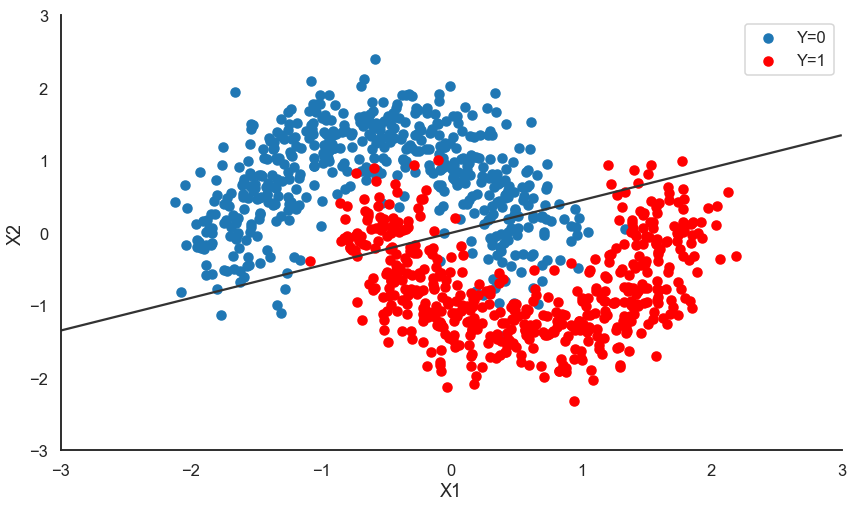

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contour(grid[0], grid[1], fit['p'].reshape(100, 100), levels=[.5], cmap='Greys', vmin=0, vmax=0.6)
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.legend()
sns.despine()

In [105]:
with pm.Model() as logistic_regression_prior:
    weights = pm.Normal('weights', mu=0, sd=.1, 
                        shape=2)
    linear = pm.math.dot(X, weights)
    class_prob = pm.math.sigmoid(linear)
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('obs', p=class_prob, observed=Y)
    
    # Estimate posterior using variational inference
    fit = pm.fit()

Average Loss = 438.16: 100%|██████████| 10000/10000 [00:10<00:00, 920.46it/s]
Finished [100%]: Average Loss = 438.14


In [16]:
ndim = X.shape[1] # 2

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

with pm.Model() as logistic_regression_prior:
    weights = pm.Normal('weights', mu=0, sd=.1, 
                        shape=ndim)
    linear = pm.math.dot(ann_input, weights)
    class_prob = pm.math.sigmoid(linear)
    p = pm.Deterministic('p', pm.math.sigmoid(pm.math.dot(grid_2d, weights)))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('obs', p=class_prob, observed=ann_output)
    
    # Find all parameters providing a good fit
    fit = pm.fit()

Average Loss = 438.16: 100%|██████████| 10000/10000 [00:08<00:00, 1153.74it/s]
Finished [100%]: Average Loss = 438.14


In [108]:
fit.mean.eval()

array([ 0.6730837, -1.0539358], dtype=float32)

In [109]:
fit.std.eval()

array([0.1424791 , 0.15005913], dtype=float32)

In [18]:
trace = fit.sample()

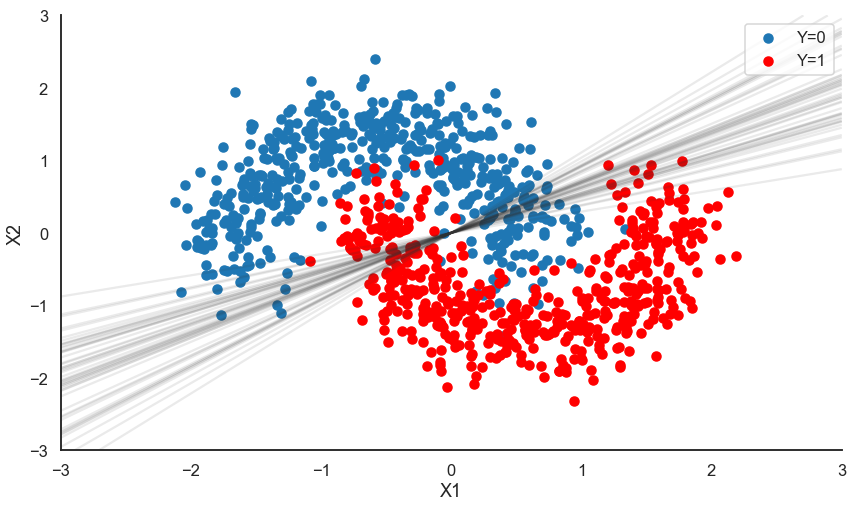

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
for i in range(50):
    contour = ax.contour(grid[0], grid[1], trace['p'][i].reshape(100, 100), 
                         levels=[.5], cmap='Greys', vmin=0, vmax=0.6, alpha=.1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.legend()
sns.despine()

In [21]:
with logistic_regression_prior:
    ann_input.set_value(grid_2d)
    ann_output.set_value(dummy_out)
    ppc = pm.sample_ppc(fit.sample())['obs']

100%|██████████| 500/500 [00:07<00:00, 68.43it/s]


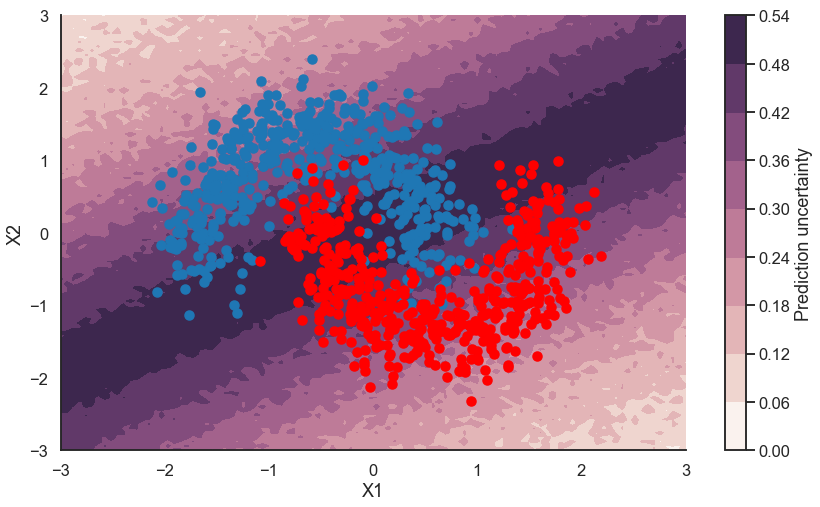

In [24]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Prediction uncertainty');
sns.despine()

In [28]:
from scipy import stats

n_grps = 20
n_data = 100
grp_means = stats.norm(loc=5, scale=5).rvs(n_grps)
data = stats.norm(loc=grp_means).rvs((n_data, n_grps))

Text(0,0.5,'count')

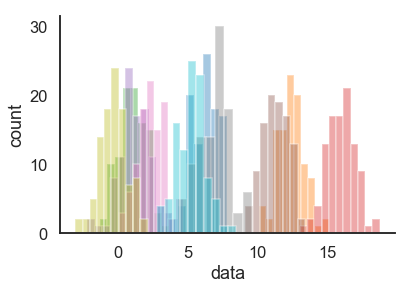

In [30]:
for i in range(10):
    sns.distplot(data[:, i], kde=False)
sns.despine()
plt.xlabel('data')
plt.ylabel('count')

In [31]:
with pm.Model() as flat_model:
    mu_grp = pm.Normal('mu_grp', mu=0, sd=10, shape=n_grps)
    pm.Normal('observed', mu=mu_grp, sd=1, observed=data)
    
    trace_flat = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_grp]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 636.33draws/s] 


In [32]:
with pm.Model() as hierarchical_model:
    mu_hyper = pm.Normal('mu_hyper', mu=0, sd=10)
    sigma_hyper = pm.HalfNormal('sigma_hyper', sd=5)
    
    mu_grp = pm.Normal('mu_grp', mu=mu_hyper, sd=sigma_hyper, 
                       shape=n_grps)
    pm.Normal('observed', mu=mu_grp, sd=1, observed=data)
    
    trace_hier = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_grp, sigma_hyper, mu_hyper]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 508.63draws/s]


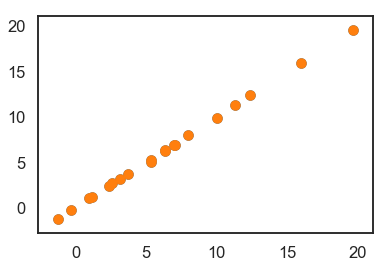

In [33]:
plt.scatter(grp_means, trace_flat['mu_grp'].mean(axis=0))
plt.scatter(grp_means, trace_hier['mu_grp'].mean(axis=0))

In [71]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

np.random.seed(42)
rotations = np.random.rand(n_grps) * 360.
n_samples = 1000
n_grps = 9
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i, rotate_by in enumerate(rotations):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    X = pm.floatX(X)
    Y = pm.floatX(Y)
    
    # Rotate the points randomly for each category
    #rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

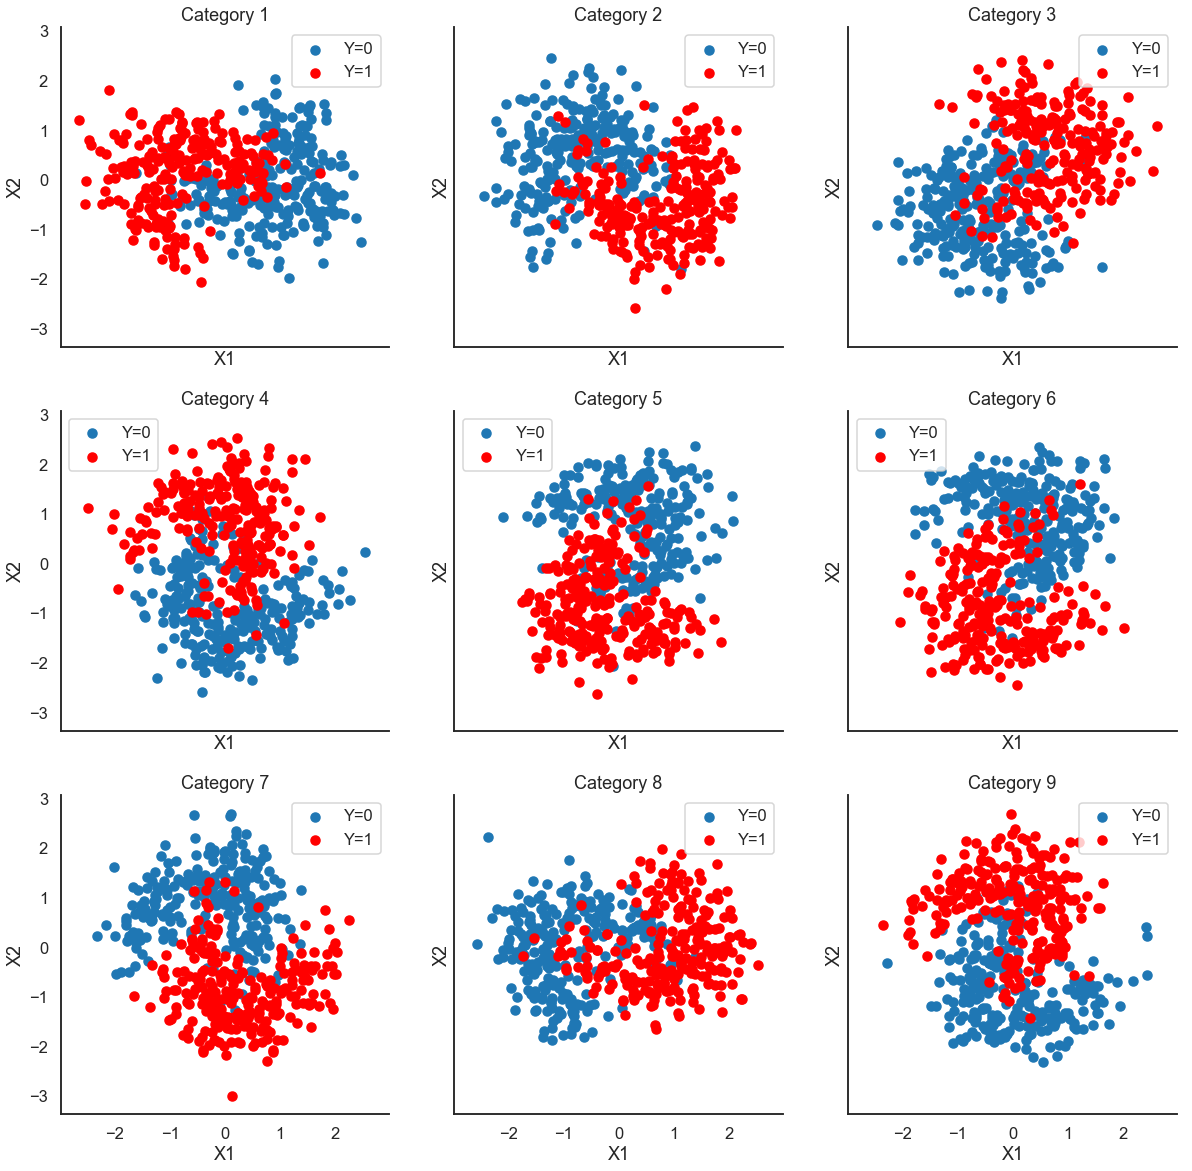

In [72]:
fig, axs = plt.subplots(figsize=(20, 20), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

In [73]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

np.random.seed(42)
rotations = np.random.randn(n_grps) * 90.
n_samples = 100
n_grps = 9
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i, rotate_by in enumerate(rotations):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    X = pm.floatX(X)
    Y = pm.floatX(Y)
    
    # Rotate the points randomly for each category
    #rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

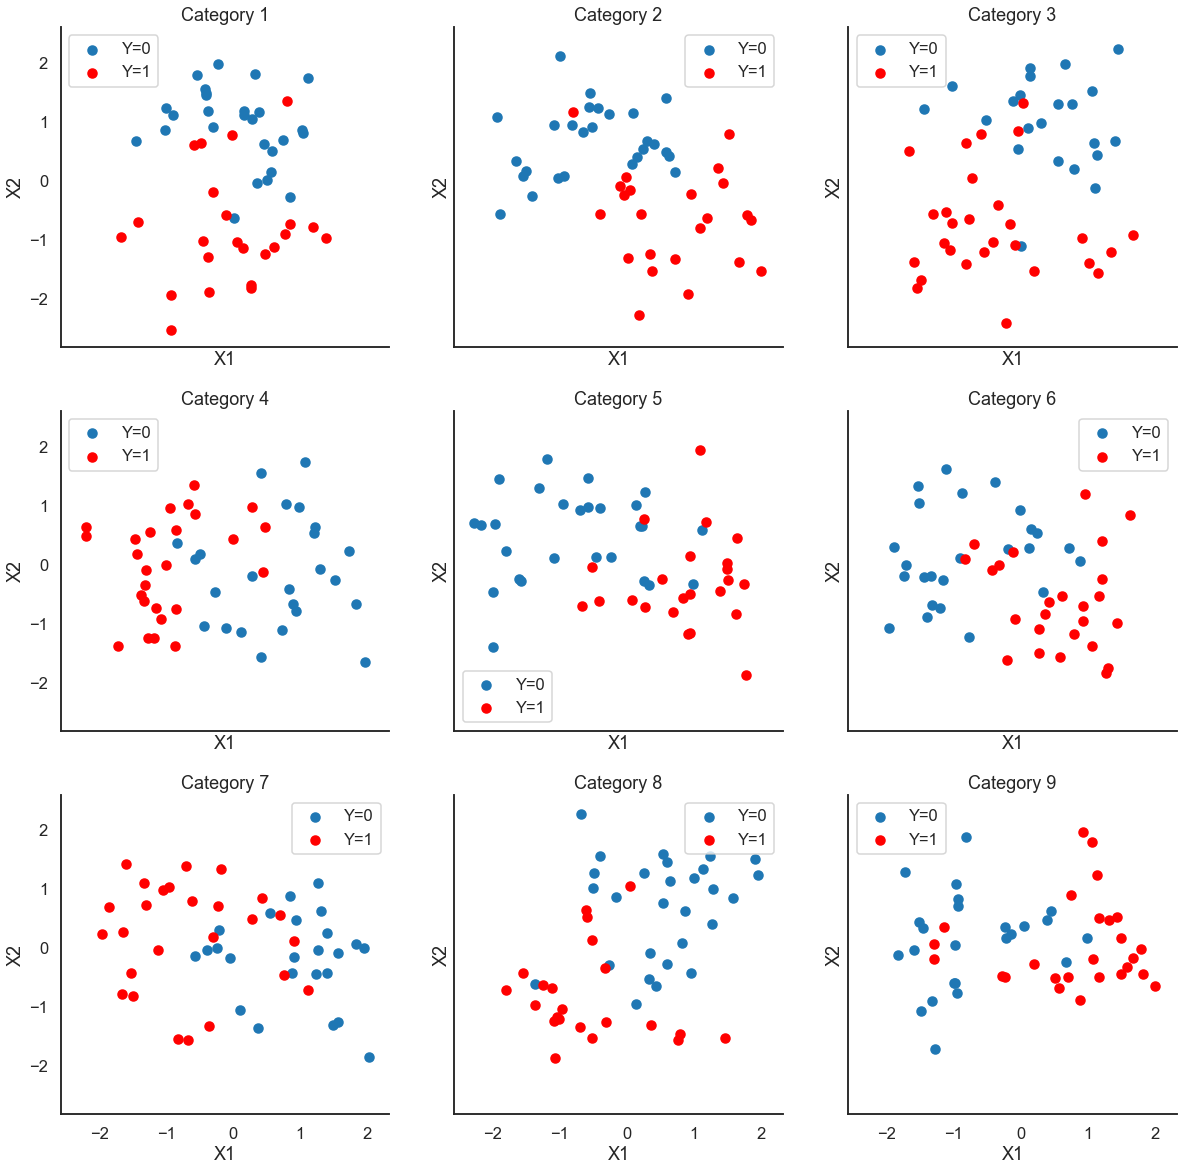

In [74]:
fig, axs = plt.subplots(figsize=(20, 20), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [13]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = pm.floatX(np.random.randn(X.shape[1], n_hidden))
    init_2 = pm.floatX(np.random.randn(n_hidden, n_hidden))
    init_out = pm.floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        pm.Deterministic('p', 
            pm.math.sigmoid(
            pm.math.dot(
                pm.math.tanh(
                    pm.math.dot(
                        pm.math.tanh(pm.math.dot(grid_2d, weights_in_1)), 
                        weights_1_2)
                ),
                weights_2_out)
            )
        )
                
                
            
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner.

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like NUTS which works pretty well in this case, but as I already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use [ADVI](https://arxiv.org/abs/1603.00788) variational inference algorithm which was recently added to `PyMC3`, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [14]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [15]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

INFO (theano.gof.compilelock): Refreshing lock /Users/twiecki/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock
Average Loss = 121.59: 100%|██████████| 50000/50000 [01:04<00:00, 772.95it/s]
Finished [100%]: Average Loss = 121.74


CPU times: user 1min 16s, sys: 10.6 s, total: 1min 27s
Wall time: 1min 58s


Performance wise that's pretty good considering that NUTS is having a really hard time. Further below we make this even faster. To make it really fly, we probably want to run the Neural Network on the GPU.

As samples are more convenient to work with, we can very quickly draw samples from the variational approximation using the `sample` method (this is just sampling from Normal distributions, so not at all the same like MCMC):

In [16]:
trace = approx.sample(draws=5000)

INFO (theano.gof.compilelock): Refreshing lock /Users/twiecki/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock


Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

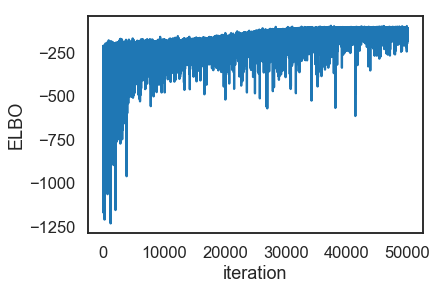

In [17]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 

In [18]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

Let's look at our predictions:

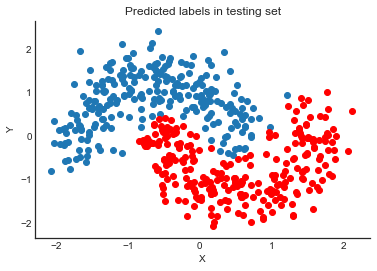

In [42]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [43]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.0%


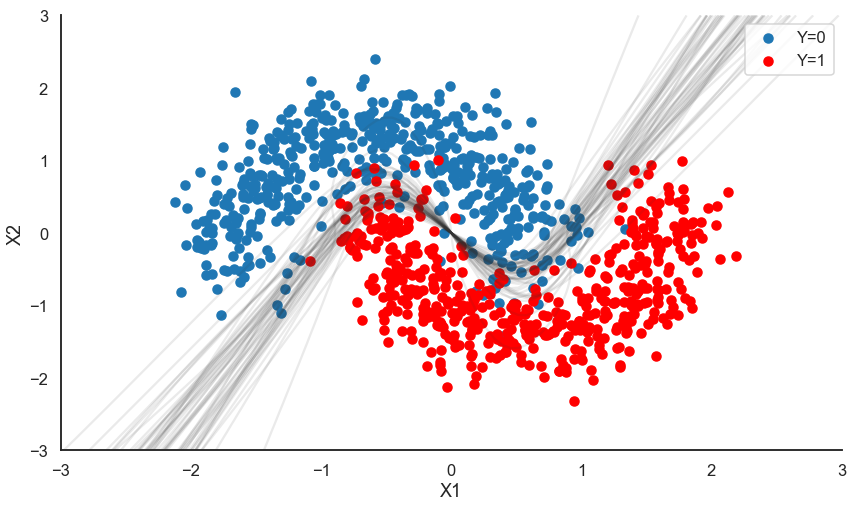

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
for i in range(50):
    contour = ax.contour(grid[0], grid[1], trace['p'][i].reshape(100, 100), 
                         levels=[.5], cmap='Greys', vmin=0, vmax=0.6, alpha=.1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
#plt.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.legend()
sns.despine()

Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [12]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

### Probability surface

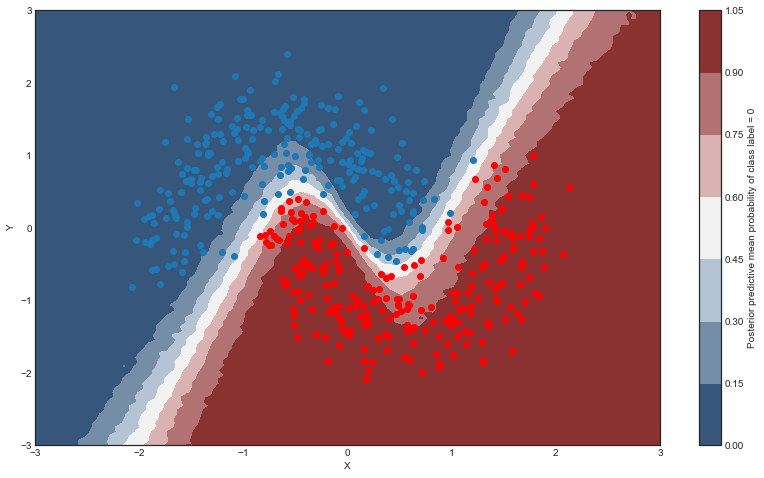

In [48]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

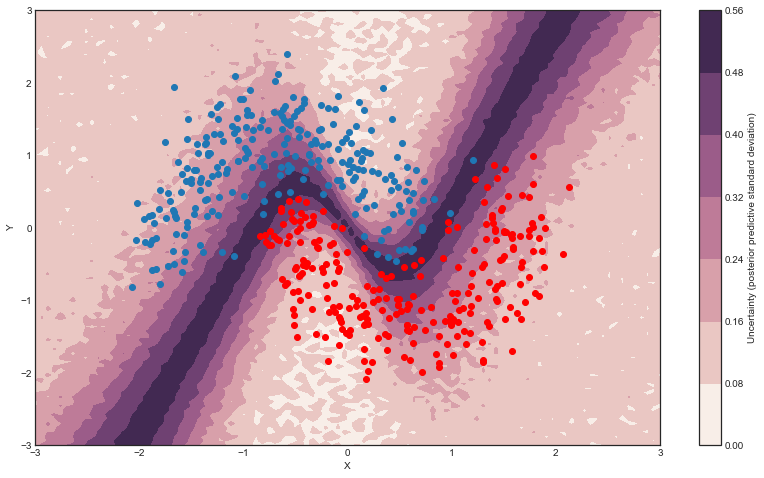

In [49]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [50]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(40000, method=inference)

Average Loss = 141.38: 100%|██████████| 40000/40000 [00:33<00:00, 1210.30it/s]
Finished [100%]: Average Loss = 141.36


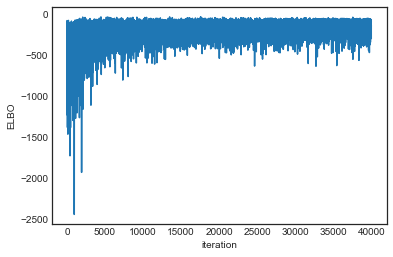

In [51]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

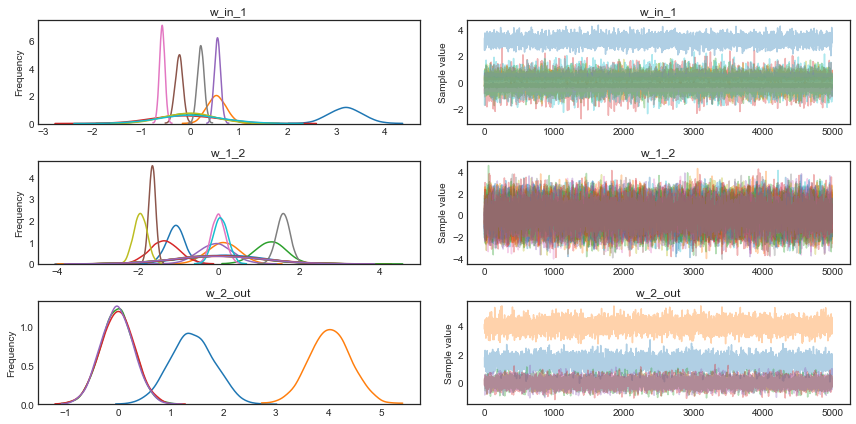

In [52]:
pm.traceplot(trace);

## Summary

Hopefully this blog post demonstrated a very powerful new inference algorithm available in PyMC3: [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi). I also think bridging the gap between Probabilistic Programming and Deep Learning can open up many new avenues for innovation in this space, as discussed above. Specifically, a hierarchical neural network sounds pretty bad-ass. These are really exciting times.

## Next steps

[`Theano`](http://deeplearning.net/software/theano/), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. See my [follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

You can also run this example on the GPU by setting `device = gpu` and `floatX = float32` in your `.theanorc`.

You might argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets, as demonstrated [here]([follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

I also presented some of this work at PyData London, view the video below:
<iframe width="560" height="315" src="https://www.youtube.com/embed/LlzVlqVzeD8" frameborder="0" allowfullscreen></iframe>

Finally, you can download this NB [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network.ipynb). Leave a comment below, and [follow me on twitter](https://twitter.com/twiecki).

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on the original ADVI implementation in PyMC3. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.